### CICC 50_min beta mean
source: https://research.cicc.com/frontend/recommend/detail?id=1781

In [4]:
import pandas as pd
import numpy as np
import os

In [8]:
data_path = '../data'
high_data = pd.read_pickle(os.path.join(data_path, 'high_data_minute.pkl'))
low_data = pd.read_pickle(os.path.join(data_path, 'low_data_minute.pkl'))
high_data.ffill()
low_data.ffill()

In [4]:
# stack and merge
high_data_stack = high_data.stack().reset_index()
high_data_stack.columns = ['Date', 'Ticker', 'high']

low_data_stack = low_data.stack().reset_index()
low_data_stack.columns = ['Date', 'Ticker', 'low']

high_low_combined = pd.merge(high_data_stack, low_data_stack, on=['Date', 'Ticker'])
high_low_combined

In [10]:
import statsmodels.api as sm
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ProcessPoolExecutor

def calculate_beta(high_low_minute_data, mode='full'):
  '''
  Calculate beta as the delta of high_t and low_t
  :param high_low_minute_data: DataFrame (stacked), high and low minute data
  :param mode: str, 'full' or 'opening' or 'closing'; 'full' for full day, 'opening' first 50-min, 'closing' for last 50-min, in a day
  :return: dict, beta_dict containing date, ticker, and the result beta
  '''
  all_tickers = high_low_minute_data['Ticker'].unique()

  output_dict = {'Date': [], 'Ticker': [], 'betas': []}

  for ticker in tqdm(all_tickers, total=len(all_tickers), desc='Calculating betas'):
    if mode == 'full':
      beta_dict = calculate_beta_per_ticker(high_low_minute_data, ticker)
    else:
      beta_dict = calculate_beta_opening_closing_hour_per_ticker(high_low_minute_data, ticker, time=mode)

    output_dict['Date'].extend(beta_dict['Date'])
    output_dict['Ticker'].extend(beta_dict['Ticker'])
    output_dict['betas'].extend(beta_dict['betas'])
    print(f'{ticker} done')

  output_df = pd.DataFrame(output_dict)
  output_df['Date'] = pd.to_datetime(output_df['Date'])

  return output_df

def calculate_beta_per_ticker(high_low_minute_data, ticker):
  '''
  Helper function: calculate beta of a target ticker
  :param high_low_minute_data: DataFrame (stacked), high and low minute data
  :param ticker: str, target ticker
  :return: dict, beta_dict containing date, ticker, and the result beta
  '''

  beta_dict = {'Date': [], 'Ticker': [], 'betas': []}
  hl_df_curr_ticker = high_low_minute_data[high_low_minute_data['Ticker'] == ticker]
  hl_df_per_day = hl_df_curr_ticker.groupby(pd.Grouper(key='Date', freq='D'))

  for date, df_day in hl_df_per_day:
    hl_df_per_hour = df_day.groupby(pd.Grouper(key='Date', freq='h'))
    for hour, df_hour in hl_df_per_hour:

      # y = high_t
      y = df_hour['high']

      # x = low_t
      x = df_hour['low']
      x = sm.add_constant(x)

      try:
        # regression
        result = sm.OLS(y, x).fit()
        beta = result.params['low']
        beta_dict['Date'].append(date.date())
        beta_dict['Ticker'].append(ticker)
        beta_dict['betas'].append(beta)
      except Exception as e:
        # reason for exception is unkonwn
        # current grouped hour has no data -> all missing value is 14:00
        print(f'Error: {e}')
        print(f'Ticker: {ticker}, Date: {date}, hour: {hour}')
        print('skip this hour')

  return beta_dict

def calculate_beta_opening_closing_hour_per_ticker(high_low_combined, ticker, time='opening'):
  '''
  Calculate beta as the delta of high_t and low_t, this time only consider opening/ending 50 minutes of a day
  (opening 50-min may contain significant information, in our opinion, rest of the day is more likely to be noise)
  
  :param high_low_minute_data: DataFrame (stacked), high and low minute data
  :param ticker: str, target ticker
  :return: DataFrame, ['Date', 'Ticker', 'betas']
  '''
  beta_dict = {'Date': [], 'Ticker': [], 'betas': []}
  hl_df_curr_ticker = high_low_combined[high_low_combined['Ticker'] == ticker]
  
  hl_df_curr_ticker['day'] = hl_df_curr_ticker['Date'].dt.date
  hl_df_per_day = hl_df_curr_ticker.groupby(pd.Grouper(key='day'))

  for date, df_day in hl_df_per_day:
    
    period_df = None
    if time == 'opening':
      period_df = df_day.head(50)
    else:
      period_df = df_day.tail(50)

    try:
      # opening hour beta
      y = period_df['high']
      x = period_df['low']
      x = sm.add_constant(x)
      result1 = sm.OLS(y, x).fit()
      beta = result1.params['low']

    except Exception as e:
      print(f'Error: {e}')
      print(f'Ticker: {ticker}, Date: {date}')
      print('skip this day')
      continue

    beta_dict['Date'].append(date)
    beta_dict['Ticker'].append(ticker)
    beta_dict['betas'].append(beta)

  beta_df = pd.DataFrame(beta_dict)
  beta_df['Date'] = pd.to_datetime(beta_df['Date'])
  return beta_dict

In [ ]:
from tqdm import tqdm

output_path = '../factor_outputs'

# NOTE: this is a very time-consuming process
beta_daily = calculate_beta(high_low_combined, mode='full')
beta_open = calculate_beta(high_low_combined, mode='opening')
beta_close = calculate_beta(high_low_combined, mode='closing')

# beta_daily.to_pickle(os.path.join(output_path, 'beta_daily.pkl'))
# beta_open.to_pickle(os.path.join(output_path, 'beta_opening_hours.pkl'))
# beta_close.to_pickle(os.path.join(output_path, 'beta_closing_hours.pkl'))

# multi-threading
'''
with ThreadPoolExecutor() as executor:
  futures = {executor.submit(calculate_beta, ticker): ticker for ticker in all_tickers}
  for future in tqdm(as_completed(futures), total=len(all_tickers), desc='Calculating betas'):
    try:
      beta_dict = future.result()
      beta_dict_all['Date'].extend(beta_dict['Date'])
      beta_dict_all['Ticker'].extend(beta_dict['Ticker'])
      beta_dict_all['betas'].extend(beta_dict['betas'])
      print(beta_dict)
    except Exception as exc:
      print(f'Ticker {futures[future]} generated an exception: {exc}')
      break
beta_df = pd.DataFrame(beta_dict_all)
hourly_beta_mean = beta_df.groupby('Ticker').apply(lambda x: x.groupby('Date').mean()).reset_index()
'''

the factor's ic is 0.018086015207168824
the factor's ir is 0.16846897194625354




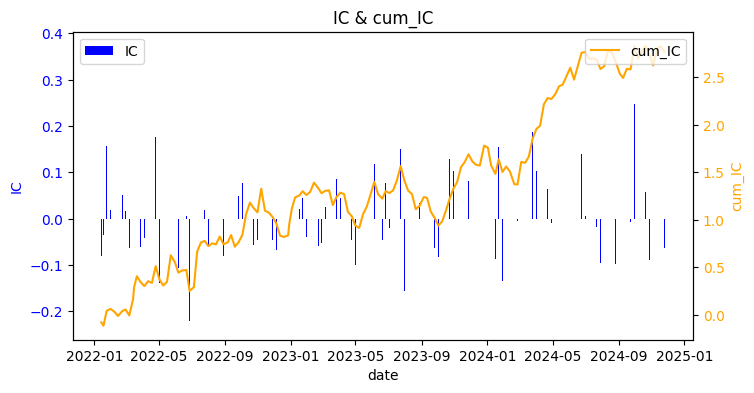

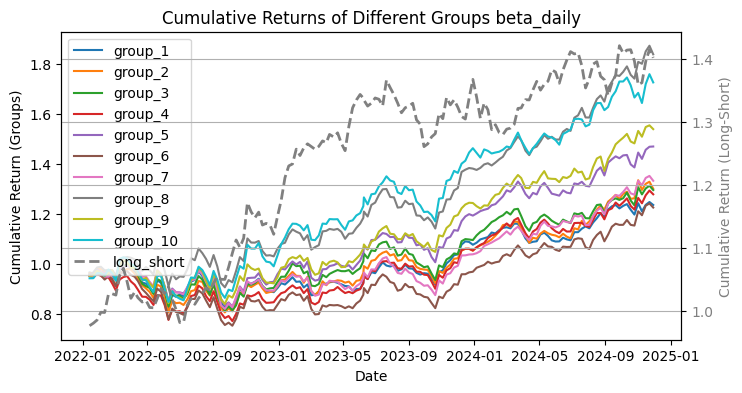


=== Backtesting statistical metrics ===
transaction_cost: 0.00%(single side)
Annualized return:
group_1       0.0832
group_2       0.1012
group_3       0.1005
group_4       0.0953
group_5       0.1414
group_6       0.0829
group_7       0.1104
group_8       0.2177
group_9       0.1596
group_10      0.2004
long_short    0.1172
dtype: float64

Annualized volatility:
group_1       0.1632
group_2       0.1683
group_3       0.1725
group_4       0.1679
group_5       0.1668
group_6       0.1775
group_7       0.1758
group_8       0.1774
group_9       0.1830
group_10      0.1981
long_short    0.1011
dtype: float64

Sharpe ratio:
group_1       0.5098
group_2       0.6013
group_3       0.5826
group_4       0.5676
group_5       0.8477
group_6       0.4670
group_7       0.6280
group_8       1.2272
group_9       0.8721
group_10      1.0116
long_short    1.1592
dtype: float64

max drawback:
group_1      -0.1668
group_2      -0.1784
group_3      -0.1858
group_4      -0.1970
group_5      -0.1645
group_

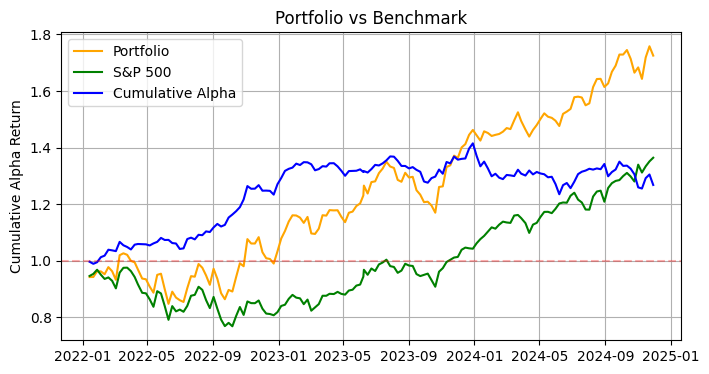


=== Long Group statistical metrics ===
Annualized return: 0.2004
Long volatility: 0.1981
Long sharpe: 1.0116
Long max drawdown: -0.1742

=== Alpha statistical metrics ===
Annualized alpha: 0.0833
Alpha volatility: 0.0956
Alpha sharpe: 0.8713
Alpha max drawdown: -0.1273


{'annual_return': 0.2004, 'sharpe': 1.0116}

In [ ]:
import util
output_path = '../factor_outputs'

all_data = pd.read_pickle(os.path.join(data_path, 'all_data.pkl'))
sp_data = pd.read_pickle(os.path.join(data_path, 'sp_500.pkl'))

beta_open = pd.read_pickle(os.path.join(output_path, 'beta_opening_hours.pkl'))
full_beta = pd.read_pickle(os.path.join(output_path, 'beta_daily.pkl'))

factor_name = 'beta_daily'

util.factor_washing(full_beta, factor_name, window_len=20)

# merge before applying function
merged_data = util.df_factor_merge(all_data, full_beta, factor_name)

util.cal_icir(merged_data, factor_name)
util.group_backtest(merged_data, factor_name, group_num=10, direction='positive', index=sp_data)